## Линейная регрессия для анализа данных о домах в Калифорнии

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

#Импортируем данные

df = pd.read_csv('D:\python\DATAS\housing.csv',sep=',')
#df = df.replace('NEAR BAY', np.nan)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
# посмотрим на распределение пропущенных значений по колонкам
df.apply(lambda x: sum(x.isnull()), axis=0)

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [3]:
#В качестве признака выберем "households"
from sklearn.linear_model import LinearRegression
#del df['total_bedrooms'] #выкинем количество спален как столбец с большим числом NaN
#del df['ocean_proximity']
X = df.drop('households', axis=1)
y = df['households']

model = LinearRegression()
model.fit(X, y)

#вычислим коэффициент детерминации
print('R^2: {0}'.format(model.score(X, y)))

ValueError: could not convert string to float: 'NEAR BAY'

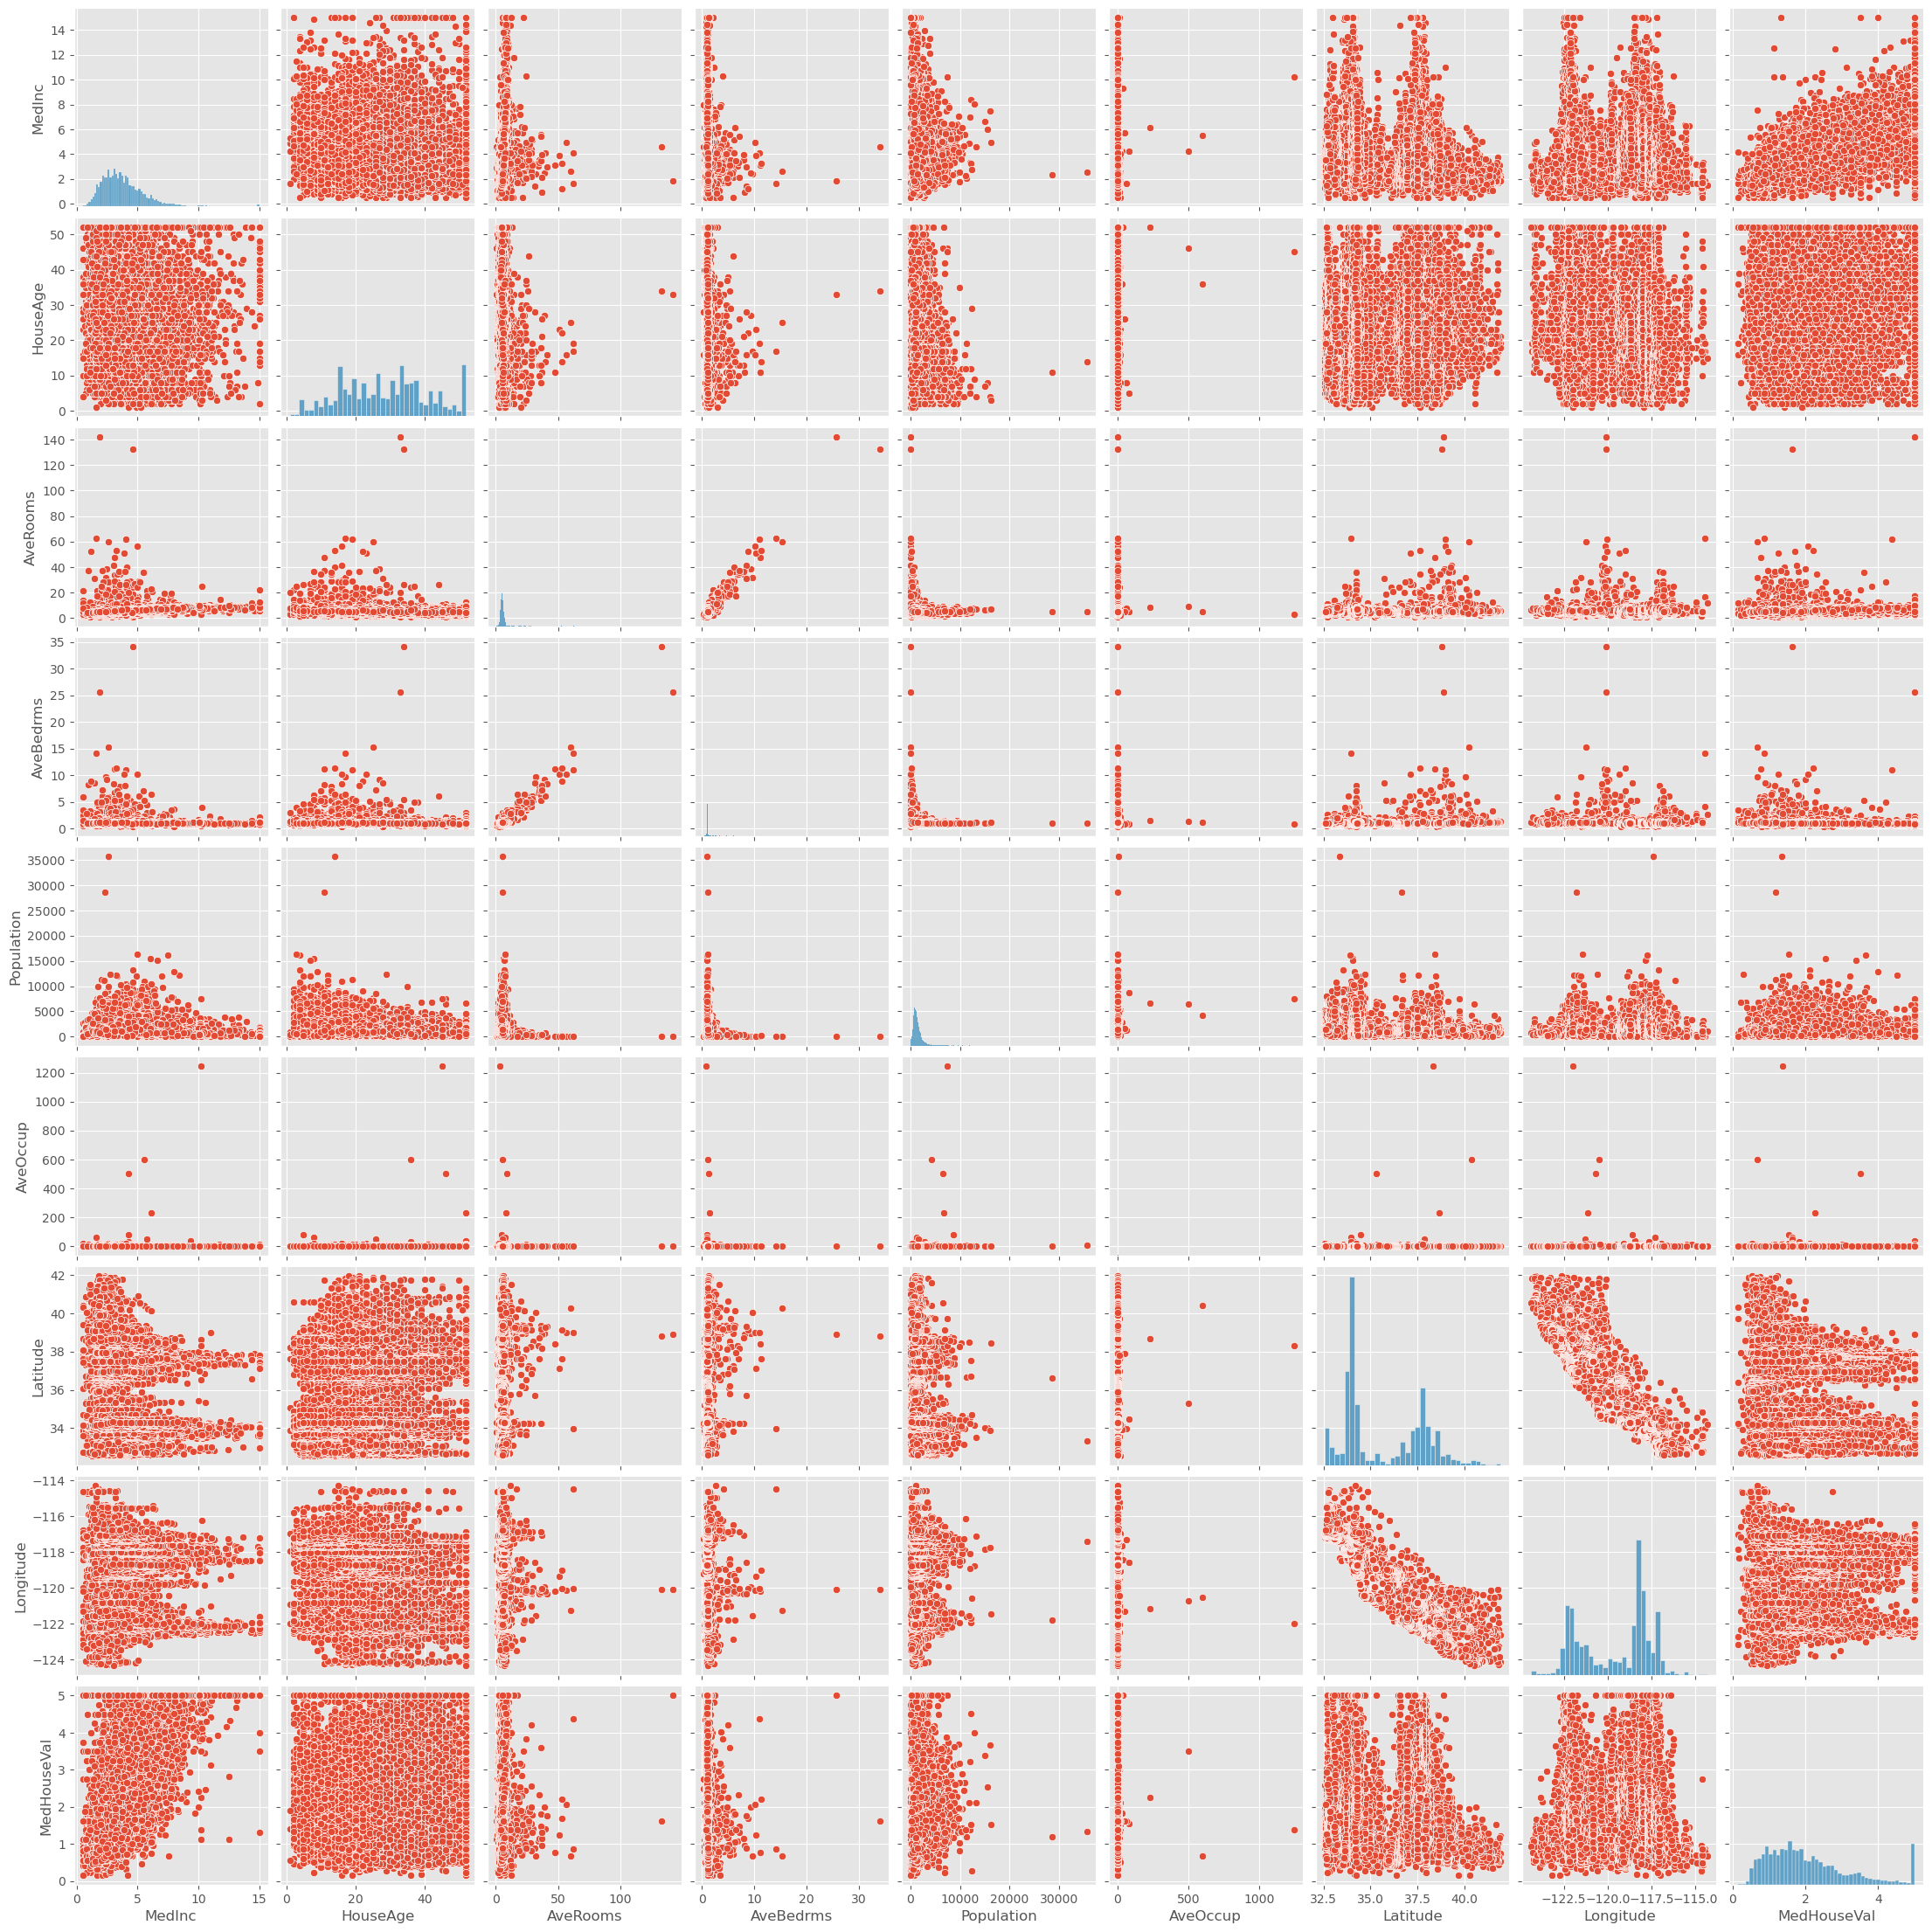

In [4]:
from sklearn.datasets import fetch_california_housing

data = pd.DataFrame(fetch_california_housing(as_frame=True).frame)
sns.pairplot(data)

plt.show()


# Лассо-регрессия

In [5]:
#Воспользуемся Лассо-регрессией
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,median_income,median_house_value,ocean_proximity
17853,-121.88,37.44,23.0,1310.0,267.0,910.0,5.3994,237900.0,<1H OCEAN
15963,-122.44,37.71,52.0,2711.0,591.0,1848.0,3.9567,251500.0,NEAR BAY
20106,-120.29,37.94,17.0,1459.0,297.0,753.0,3.0500,144800.0,INLAND
15525,-117.05,33.14,16.0,4552.0,1166.0,2737.0,2.2500,136300.0,<1H OCEAN
5234,-118.23,33.94,39.0,1141.0,258.0,1313.0,2.0187,90100.0,<1H OCEAN


In [6]:
#Во избежание утечки данных стандартизацию числовых признаков 
#выполним после разделения данных и только на основе обучающих данных
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train) 

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

print(X_train)

ValueError: could not convert string to float: '<1H OCEAN'

In [7]:
#применим лассо-регрессию к обучающей выборке с  параметром регуляризации α=1.
from sklearn.linear_model import Lasso

reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

Lasso(alpha=1)

ValueError: could not convert string to float: '<1H OCEAN'

In [ ]:
#Оценка модели
print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

In [ ]:
#MSE для обучающего и тестового набора.
from sklearn.metrics import mean_squared_error

# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)

print('MSE test set', round(mse_test, 2))

In [ ]:
#рассмторим коэффициенты лассо как функцию альфы
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [ ]:
#выберем наилучшее альфа
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

model.alpha_

In [ ]:
# используем лучшее альфа для нашей модели
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=2.3441244939374593)

print(list(zip(lasso_best.coef_, X)))

In [ ]:
#Проведем оценку модели
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

mean_squared_error(y_test, lasso_best.predict(X_test))

In [ ]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0, 50000
plt.ylim(ymin, ymax);

In [ ]:
x1=np.arange(1,100).reshape(-1, 1)
y1 = np.array(df['median_income'].iloc[1:100]).reshape(-1, 1)
#y1 = np.array(df['median_house_value'].iloc[1:100]).reshape(-1, 1)

from sklearn import linear_model 
from sklearn.metrics import r2_score
reg1 = linear_model.LinearRegression().fit(x1, y1)
print('R^2 = ', reg1.score(x1, y1))
y1_pred = reg1.predict(y1)

import matplotlib.pyplot as plt
plt.scatter(x1, y1)
plt.plot(x1, y1, ls = '-', color='red')
plt.plot(x1, y1_pred, ls = '-', color='green')
plt.ylabel("median_income")
plt.ylim(0,6000)

# Список использованных источников

1) https://www.youtube.com/watch?v=_PlC8Niun7U&list=LL&index=2&ab_channel=ComputerScienceCenter

2) https://www.youtube.com/watch?v=5n1jCfhjet0&list=LL&index=1&ab_channel=DeepLearningSchool

3) https://www.kirenz.com/post/2019-08-12-python-lasso-regression-auto/